## EC460-NNDL
## Assign-5: 1D CNN, RNNs and 2D CNN with Applications
### Name: Nishanth Maurya Mocharla
### Roll no: 191EC226

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
import scipy
import copy
import tqdm.notebook as tqdm
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import glob as gb
from matplotlib import rcParams
from IPython.display import display
from sklearn.utils import shuffle
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image

from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix , classification_report, precision_score

## Q.1)
### Build a  1D CNN model from Scratch (using Numpy) to recognize human activity using HAR dataset (https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) (split dataset into training dataset (80%) and  testing dataset (20%) ). For implementation, use a  Adam  gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Focal loss function 
#### (i) Visualize HAR dataset      
#### (ii) Plot a comparative loss curve for at least 100 epochs.
#### (iii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test dataset and ROC curve   
#### (iv)  Implement above 1D CNN model with Keras/Tensorflow/Pytorch Library and verify the above results. 


In [ ]:
# Data visualization

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/nitk/assignments/assignment5/train.csv')
test = pd.read_csv('/content/drive/MyDrive/nitk/assignments/assignment5/train.csv')
print(train.shape, test.shape)

columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

(7352, 563) (2947, 563)


Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'fBodyBodyGyroJerkMagkurtosis', 'angletBodyAccMeangravity',
       'angletBodyAccJerkMeangravityMean', 'angletBodyGyroMeangravityMean',
       'angletBodyGyroJerkMeangravityMean', 'angleXgravityMean',
       'angleYgravityMean', 'angleZgravityMean', 'subject', 'Activity'],
      dtype='object', length=563)

In [ ]:
train.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'fBodyBodyGyroJerkMagkurtosis', 'angletBodyAccMeangravity',
       'angletBodyAccJerkMeangravityMean', 'angletBodyGyroMeangravityMean',
       'angletBodyGyroJerkMeangravityMean', 'angleXgravityMean',
       'angleYgravityMean', 'angleZgravityMean', 'subject', 'Activity'],
      dtype='object', length=563)

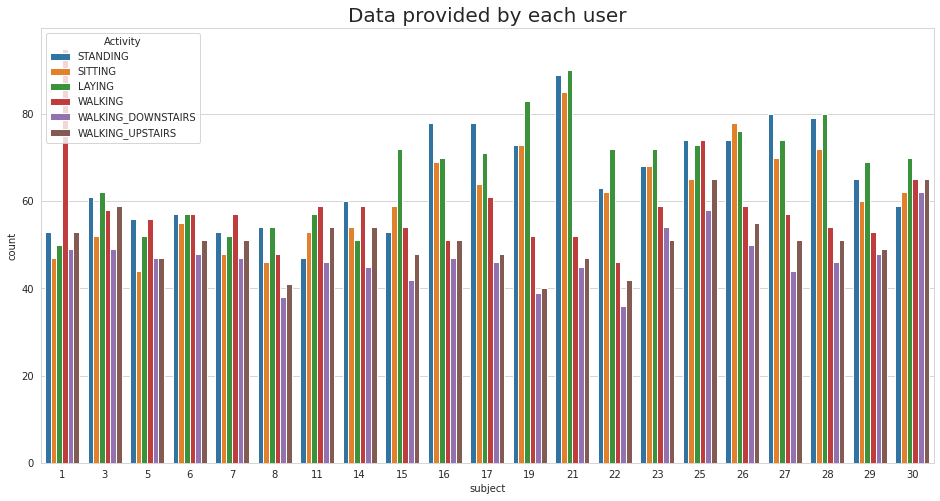

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(data = train,x='subject',hue='Activity')
plt.show()

In [ ]:
import plotly
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib as mlt

# Plotting data
label_counts = train['Activity'].value_counts()

# Get colors
n = label_counts.shape[0]
colormap = plt.get_cmap('viridis')
colors = [mlt.colors.to_hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone ActivityName Distribution',
                   xaxis = dict(title = 'ActivityName'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
fig.show()
#iplot(fig)

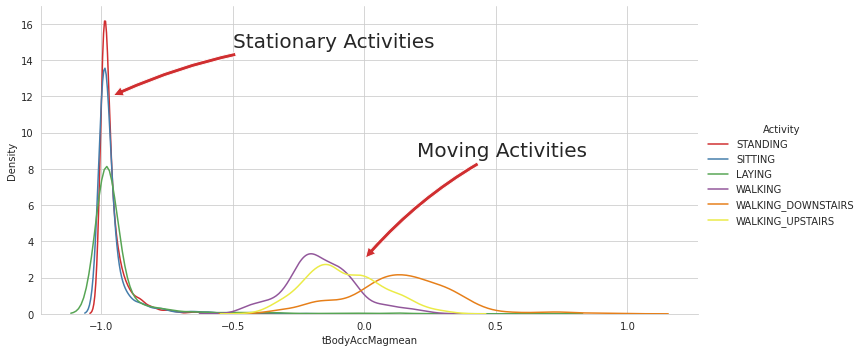

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='Activity', height=5,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.960,12), xytext=(-0.5, 15), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()


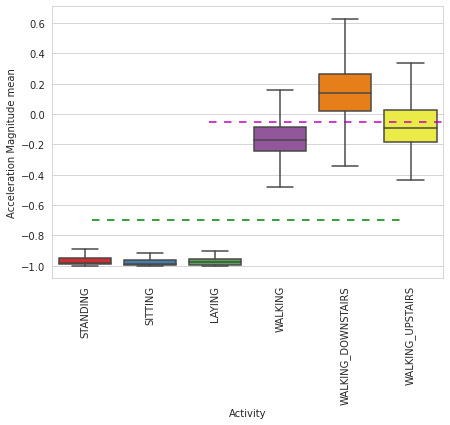

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x='Activity', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

In [ ]:
path = "/content/drive/MyDrive/nitk/assignments/assignment5/UCI-HAR-Data/"
x_train = pd.read_csv(path+'train/X_train.txt',header=None,delim_whitespace=True)
y_train = pd.read_csv(path+'train/y_train.txt',header=None,delim_whitespace=True)
x_test = pd.read_csv(path+'test/X_test.txt',header=None,delim_whitespace=True)
y_test = pd.read_csv(path+'test/y_test.txt',header=None,delim_whitespace=True)
print(x_train.info())
x_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB
None


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [ ]:
print(y_train.info())
y_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB
None


,0
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


In [ ]:
# used as a 1D layer
class conv2d_layer:
    def __init__(self,shape,n,anything_else = None):
        self.w = np.random.rand(n,shape[0],shape[1],shape[2])/(np.product(shape)+1)
        self.b = np.random.rand(n)/(np.product(shape)+1)
        self.n = n
        
    def forward(self,Image):    
        
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape

        _ , x_k , y_k = self.w[0].shape

        out_x = x-x_k+1
        out_y = y-y_k+1
        
        output = []
        
        for pos in range(self.n):
            out = np.zeros((out_x,out_y))
            
            for i in range(out_x):
                for j in range(out_y):
                    out[i,j] = np.sum(Image[:,i:i+x_k,j:j+y_k]*self.w[pos]) + self.b[pos]
            output = output + [out]
        output = np.array(output)      
        return output
    
    def reverse(self,Image,Errors):
        
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape
        _ ,x_k,y_k = self.w[0].shape
        err_x,err_y = Errors[0].shape
        
        output = np.zeros_like(Image,Errors.dtype)
        for layer in range(self.n):
            for i in range(err_x):
                for j in range(err_y):
                    output[:,i:i+x_k,j:j+y_k] += Errors[layer,i,j]*self.w[layer]
                    self.w[layer] = self.w[layer] - Errors[layer,i,j]*Image[:,i:i+x_k,j:j+y_k]
                    self.b[layer] = self.b[layer] - Errors[layer,i,j]
        return output
    
    def display(self):
        print("\n**********Convolution Parameters**********")
        print("Weights are:\n", self.w)
        print("Bias is:\n ", self.b)
        print("#Kernels is:\n ", self.n)
        
# tanh
class tanh:
    
    def forward(self,Input):
        exp = np.exp(-2*Input)
        output = (1-exp)/(1+exp)
        return output
    
    def reverse(self,Input,Errors):
        der = 1-np.square(self.forward(Input))
        output = der*Errors
        return output
    
# AveragePooling2D (Used as 1D)
class AveragePooling2D:
    
    def __init__(self,shape,stride,anything_else = None):
        self.shape = shape
        self.stride = stride
        
    def forward(self,Image):  
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
            
        x,y = Image[0].shape
        s=self.stride
        x_k,y_k = self.shape
        
        out_x = (x-x_k)//s+1
        out_y = (y-y_k)//s+1

        output = []
        for pos in range(Image.shape[0]):
            
            out = np.zeros((out_x,out_y))

            for i in range(out_x):
                for j in range(out_y):
                    out[i,j] = np.mean(Image[0][i*s:i*s+x_k,j*s:j*s+y_k])
            output = output + [out]
            
        output = np.array(output)
        
        return output
    
    def reverse(self,Image,Errors):
        if(len(Image.shape)==2):
            Image=np.reshape(Image,(1,Image.shape[0],Image.shape[1]))
        
        x,y = Image[0].shape
        x_k,y_k = self.shape
        err_x,err_y = Errors[0].shape
            
        output = []
        for pos in range(Image.shape[0]):

            out = np.zeros_like(Image[pos],Errors.dtype)

            for i in range(err_x):
                for j in range(err_y):
                    out[i:i+x_k,j:j+y_k] += Errors[pos,i,j]/(x_k*y_k)
            output = output + [out]
        output = np.array(output)
        return output
    
# Flatten
class flatten():
    
    def forward(self,Image):
        output = np.reshape(Image,np.product(Image.shape))
        return output
    
    def reverse(self,Image,errors):
        output = np.reshape(errors,Image.shape)
        return output

# Dense
class fully_connected():
    def __init__(self,input_size,n):
        
        self.w = np.random.rand(n,input_size)/(input_size+1)
        self.b = np.random.rand(n)/(input_size+1)
        self.n = n
    
    def forward(self,Input):
        output = []
        for layer in range(self.n):
            out = np.dot(Input,self.w[layer]) + self.b[layer]
            output = output + [out]
        output = np.array(output)
        return output
    
    def reverse(self,Input,errors):
        
        output = np.zeros_like(Input)
        for layer in range(self.n):
            self.w[layer] = self.w[layer] - errors[layer]*Input
            self.b[layer] = self.b[layer] - errors[layer]
            output = output + errors[layer]*self.w[layer]   
        output = np.array(output)
        return output
    
# softmax
class softmax():
    
    def forward(self,Input):

        Numerator = np.exp(Input)
        output = Numerator/sum(Numerator)
        
        return (output)
    
    def reverse(self,Input,errors):
            
        Soft = self.forward(Input)
        
        Soft_list = np.array([list(Soft)] * len(Soft))
        derivative = Soft_list.T*(np.identity(len(Soft)) - Soft_list)
        
        output = np.matmul(errors,derivative)
        
        return output

def SoftmaxLoss(truth,predicted):
    
    loss = -1* np.sum(truth*np.log(predicted))
    
    Numerator = np.exp(predicted)
    softmax = Numerator/sum(Numerator)
        
    grad = softmax
    grad[truth == 1] = softmax[truth == 1] - 1
    
    return (loss,grad)
# Must work for both adam as well as SGD algos

In [ ]:
Model = [] #Input = 1*561

#Layer 0
Model = Model + [conv2d_layer((1,10,1),50)] #Out = 50*552*1

#Layer 1
Model = Model + [tanh()] #Out = 50*552*1

#Layer 2
Model = Model + [AveragePooling2D((3,1),3)] #Out = (50, 184, 1)

#Layer 3
Model = Model + [conv2d_layer((50,5,1),16)] #Out = (16, 180, 1)

#Layer 4
Model = Model + [tanh()] #Out = (16, 180, 1)

#Layer 5
Model = Model + [AveragePooling2D((3,1),3)]# Out = (16, 60, 1)

#Layer 6
Model = Model + [conv2d_layer((16,5,1),1)] #Out = (1, 56, 1)

#Layer 7
Model = Model + [tanh()] #Out = (1, 56, 1)

#Layer 8
Model = Model + [flatten()] #Out = 56

#Layer 9
Model = Model + [fully_connected(56,6)] #Out = 6

#Layer 10
Model = Model + [tanh()] #Out = 6

# #Layer 11
# Model = Model + [fully_connected(6,6)] #Out = 10

#Layer 12
Model = Model + [softmax()] #Out = 6

In [ ]:
epochs = 3
Recorded_loss = []
Learning_rate = 0.01

x_train,y_train = shuffle(x_train,y_train)

x_train = np.array(x_train[:50])
y_train = np.array(y_train[:50])


n_layers = len(Model)
for ep in tqdm.tqdm(range(epochs),leave=True,desc = "Epochs"):
    
    Data = tqdm.tqdm(zip(x_train,y_train),total = len(y_train),leave=False,desc = "Images")
    
    for Input_img,truth in Data:
        truth_onehot = np.array([0]*6)
        truth_onehot[truth-1] = 1
        outputs = [np.reshape(Input_img,(1,Input_img.shape[0],1))]
        
        for i in range(n_layers):
            out = Model[i].forward(outputs[-1])
            outputs += [out.copy()]
            
    
        Loss, error = SoftmaxLoss(truth_onehot,outputs[-1])
        error = error * Learning_rate
        Recorded_loss += [Loss] 
        
        Data.set_description("Current loss is: {}".format(np.round(Loss,5)))
        Data.refresh()
        
        error = [error]
        for i in range(n_layers-1,-1,-1):
            out = Model[i].reverse(outputs[i],error[-1])
            error += [out.copy()]    
    Data.set_description("Completed")
    Data.refresh()

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Images:   0%|          | 0/50 [00:00<?, ?it/s]

Images:   0%|          | 0/50 [00:00<?, ?it/s]

Images:   0%|          | 0/50 [00:00<?, ?it/s]

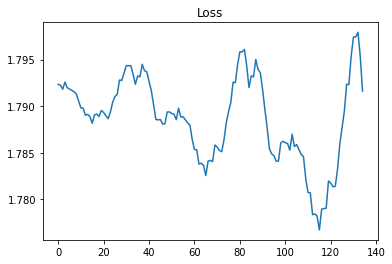

In [ ]:
val = 15
Avg_loss = []
for i in range(len(Recorded_loss)-val):
    Avg_loss +=  [np.mean(Recorded_loss[i:i+val])]

plt.figure()
plt.title("Loss")
plt.plot(Avg_loss)

In [ ]:
prediction = []

test_set = np.array(x_test[0:50])
y_test = np.array(y_test[0:50])
y_test = np.reshape(y_test,y_test.shape[0])
print(y_test)
for Input_img in tqdm.tqdm(test_set,total = len(test_set)):
    outputs = [np.reshape(Input_img,(1,Input_img.shape[0],1))]
    for i in range(n_layers):
        out = Model[i].forward(outputs[-1])
        outputs += [out.copy()]
    prediction += [np.argmax(out)]
    
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(prediction, name='Predicted')

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


  0%|          | 0/50 [00:00<?, ?it/s]

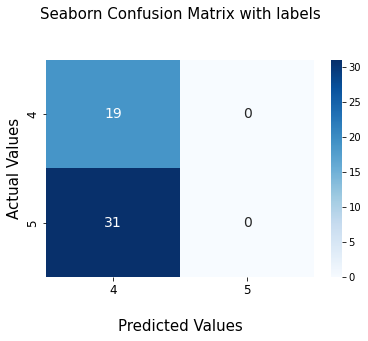

In [ ]:
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_actu,y_pred)

import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',annot_kws={"size":14})

ax.set_title('Seaborn Confusion Matrix with labels\n\n',fontsize = 15);
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values',fontsize = 15);

ax.xaxis.set_ticklabels(['4','5'],fontsize = 12)
ax.yaxis.set_ticklabels(['4','5'],fontsize = 12)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
labels = np.array([0,1,2,3,4,5])
print(classification_report(y_test,prediction,labels=labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.38      1.00      0.55        19
           5       0.00      0.00      0.00        31

   micro avg       0.38      0.38      0.38        50
   macro avg       0.06      0.17      0.09        50
weighted avg       0.14      0.38      0.21        50



##Q.2)
### Build a  AlexNet CNN  model  (using Keras/Tensorflow/Pytorch)  to recognize breast cancer from Breast Dataset (Use Sklearn Dataset and  split dataset into training dataset (80%) and  testing dataset (20%) ). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the  CNN model for Focal loss function.  
#### (i) Plot a comparative loss curve for at least 100 epochs.
#### (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test datset and ROC curve for each loss function.


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPool1D
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data = data.data, columns= data.feature_names )
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y = data.target

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.1,stratify=y)
X_train.shape,y_train.shape

((512, 30), (512,))

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=16,kernel_size=2,activation='relu',input_shape=(30,1)))
model.add(Conv1D(32,2,activation='relu'))
model.add(Flatten())
model.add(keras.layers.Dense(10,activation = 'sigmoid'))
model.add(keras.layers.Dense(5,activation = 'sigmoid'))
model.add(keras.layers.Dense(3,activation = 'sigmoid'))
model.add(keras.layers.Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 29, 16)            48        
                                                                 
 conv1d_17 (Conv1D)          (None, 28, 32)            1056      
                                                                 
 flatten_8 (Flatten)         (None, 896)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                8970      
                                                                 
 dense_26 (Dense)            (None, 5)                 55        
                                                                 
 dense_27 (Dense)            (None, 3)                 18        
                                                                 
 dense_28 (Dense)            (None, 1)                

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,epochs=50)

Epoch 1/50
16/16 [==============================] - 1s 5ms/step - loss: 0.6325 - accuracy: 0.6133
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5484 - accuracy: 0.6270
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.8828
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.3732 - accuracy: 0.9668
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.2978 - accuracy: 0.9746
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.2420 - accuracy: 0.9805
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9824
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9746
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1617 - accuracy: 0.9727
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.9727
Epoch 11/50
16/16 [

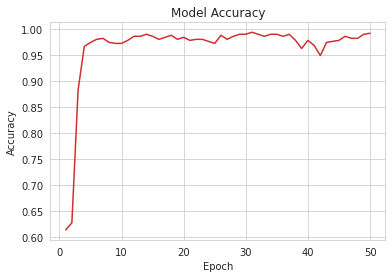

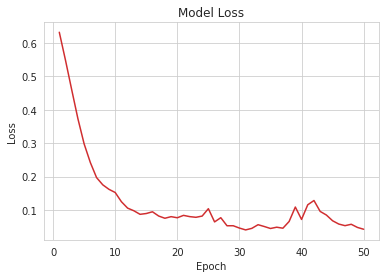

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

plotLearningCurve(history,50)

In [ ]:
y_preds = model.predict(X_test)
y_preds = np.round(y_preds)

In [ ]:
print(classification_report(y_test,y_preds,labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        36

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



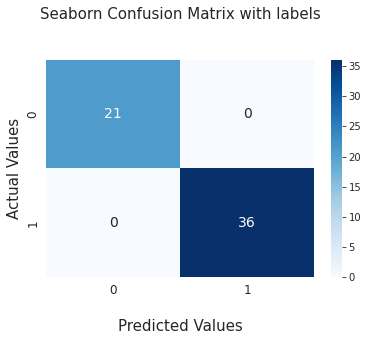

In [ ]:
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test,y_preds)

import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',annot_kws={"size":14})

ax.set_title('Seaborn Confusion Matrix with labels\n\n',fontsize = 15);
ax.set_xlabel('\nPredicted Values',fontsize = 15)
ax.set_ylabel('Actual Values',fontsize = 15);

ax.xaxis.set_ticklabels(['0','1'],fontsize = 12)
ax.yaxis.set_ticklabels(['0','1'],fontsize = 12)
plt.show()

##Q.3)
### Build a  VGG16 CNN  model  (using Keras/Tensorflow/Pytorch)  to  classify ‘cloudy’, ‘desert’, ‘green_area’, and ‘water, using Satellite image Classification Dataset-RSI-CB256 (https://www.kaggle.com/mahmoudreda55/satellite-image-classification).This dataset has 4 different classes mixed from Sensors and google map snapshot. Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the  CNN model for Softmax loss function.  
#### (i) Plot a comparative loss curve for at least 100 epochs. 
#### (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test datset and ROC curve for each loss function.


In [ ]:
def loaddata():
    dataset="/content/drive/MyDrive/nitk/assignments/assignment5/data3/"
    label_names = ["cloudy","desert","green_area","water"]

    images=[]
    labels=[]
    for folder in os.listdir(dataset):
        files=gb.glob(pathname=str(dataset+folder+"/*.jpg"))
        
        label = label_names.index(folder)
        for file in files:
            #read the image
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # resize the image
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    

    return images,labels

In [ ]:
images,labels=loaddata()

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(unique)
print(counts)

[0 1 2 3]
[1500 1131 1500 1500]


Text(0.5, 1.0, 'No of Data avaliable for each class')

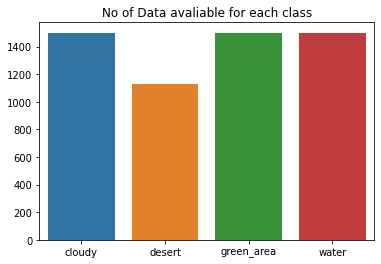

In [ ]:
import seaborn as sns
label_names = ["cloudy","desert","green_area","water"]
unique, counts = np.unique(labels, return_counts=True)
sns.barplot(x = label_names, y = counts )
plt.title('No of Data avaliable for each class')

In [ ]:
labels = np.array(pd.get_dummies(labels))
images,labels = shuffle(images,labels, random_state=64)
X_train, X_Test, y_train, y_Test = train_test_split(images,labels, test_size=0.99, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_Test, y_Test, test_size=0.995, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(56, 224, 224, 3)
(27, 224, 224, 3)
(5548, 224, 224, 3)
(56, 4)
(27, 4)
(5548, 4)


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
history = model.fit(X_train,y_train,epochs = 5)

Epoch 1/5
2/2 [==============================] - 113s 48s/step - loss: 51884341592064.0000 - acc: 0.2143
Epoch 2/5
2/2 [==============================] - 109s 48s/step - loss: 341656160.0000 - acc: 0.3214
Epoch 3/5
2/2 [==============================] - 108s 47s/step - loss: 6498986496.0000 - acc: 0.1786
Epoch 4/5
2/2 [==============================] - 107s 46s/step - loss: 2673754624.0000 - acc: 0.3214
Epoch 5/5
2/2 [==============================] - 124s 60s/step - loss: 55370180.0000 - acc: 0.2500


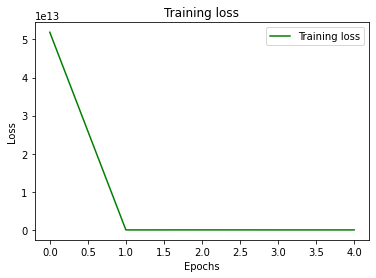

In [ ]:
loss_train = history.history['loss']
# epochs = range(0,5)
plt.plot(loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    Y_pred = []
    Y_Test = []
    for i in range(len(y_pred)):
        Y_pred.append(np.argmax(y_pred[i]))
        Y_Test.append(np.argmax(y_test[i]))

    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_Test, Y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_Test, Y_pred)
    
    accuracy = precision_score(Y_Test, Y_pred, average=None)

    categories  = ["cloudy","desert","green_area","water"]



    print("Confusion Matrix:")

    print(cf_matrix)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix\n\n',fontdict = {'size':14}, pad = 10)
    ax.set_xlabel('\nPredicted values',fontdict = {'size':14}, labelpad = 10)
    ax.set_ylabel('Actual values ',fontdict = {'size':18}, labelpad = 20);

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    print("Accuracy for each class: ")
    
    for i in range(len(accuracy)):
        print(f"{categories[i]}:  {format(accuracy[i], '.2f')}%")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        11
           3       0.22      1.00      0.36         6

    accuracy                           0.22        27
   macro avg       0.06      0.25      0.09        27
weighted avg       0.05      0.22      0.08        27

Confusion Matrix:
[[ 0  0  0  7]
 [ 0  0  0  3]
 [ 0  0  0 11]
 [ 0  0  0  6]]


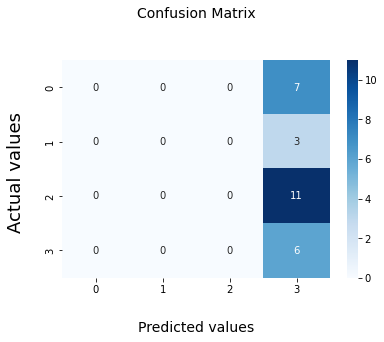

Accuracy for each class: 
cloudy:  0.00%
desert:  0.00%
green_area:  0.00%
water:  0.22%


In [ ]:
model_Evaluate(model)

## Q.4.
### (a)  Python Implementation  of LSTM  from Scratch (using NumPy  for   Binary to  Octal  conversion) 

In [ ]:
temp = [np.random.randint(1023) for i in range(1000)]
x = np.array([[[int(j)] for j in '{0:010b}'.format(i)] for i in temp])
y = np.array([[[int(j)] for j in '{0:04o}'.format(i)] for i in temp])
print(x.shape,y.shape)

(1000, 10, 1) (1000, 4, 1)


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(10, input_shape=(10,1)))
model.add(keras.layers.Dense(10,activation ="tanh"))
model.add(keras.layers.Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, batch_size=1,  verbose=0,callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
test = np.array([[[0],[0],[0],[0],[0],[0],[0],[1],[1],[0]]])
print("Binary: ",test)
prediction = model.predict(test)
print("Octal: ",np.round(prediction[0]))

Binary:  [[[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [1]
  [0]]]
Octal:  [ 0. -0.  0.  6.]


### (b) Python Implementation of LSTM  from Scratch    to   classify    blues,  classical, country, disco , hiphop, jazz, metal, pop, reggae, rock  using GTZAN Dataset-Music Genre Classification (https://www.kaggle.com/code/kallepallishalini/musicgenreclassificationusingrnn/data). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the  CNN model for Softmax loss function.  (i) Plot a comparative loss curve for at least 100 epochs.  (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy on test datset and ROC curve for each loss function.

In [ ]:
import json
import os
import math
import librosa

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/nitk/assignments/assignment5/data4b"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13
n_fft=2048
hop_length=512
num_segments = 10
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [ ]:
# dictionary to store mapping, labels, and MFCCs
data = {
    "mapping": [],
    "labels": [],
    "mfcc": []
}
# loop through all genre sub-folder
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    # ensure we're processing a genre sub-folder level
    if dirpath is not DATASET_PATH:

        # save genre label (i.e., sub-folder name) in the mapping
        dirpathSplit = dirpath.split("/")
        semantic_label = dirpathSplit[-1]
        if('genres_original' in dirpathSplit and 'jazz' not in dirpathSplit):
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-15)
                        #print("{}, segment:{}".format(file_path, d+1))


Processing: genres_original

Processing: country

Processing: classical

Processing: blues

Processing: pop

Processing: hiphop

Processing: reggae

Processing: metal

Processing: disco

Processing: rock


In [ ]:
for i in range(len(data['labels'])):
    data['labels'][i] += 2

In [ ]:
print(np.unique(np.array(data['labels'])))

[0 1 2 3 4 5 7 8 9]


In [ ]:
def prepare_datasets(test_size, validation_size):

    # load data
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13

model = keras.Sequential()
# 2 LSTM layers
model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(keras.layers.LSTM(64))
# dense layer
model.add(keras.layers.Dense(64, activation='relu'))
# output layer
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
169/169 [==============================] - 33s 172ms/step - loss: 1.6752 - accuracy: 0.3845 - val_loss: 1.5513 - val_accuracy: 0.4296
Epoch 2/50
169/169 [==============================] - 28s 165ms/step - loss: 1.4861 - accuracy: 0.4545 - val_loss: 1.3580 - val_accuracy: 0.4800
Epoch 3/50
169/169 [==============================] - 33s 193ms/step - loss: 1.3982 - accuracy: 0.4856 - val_loss: 1.3092 - val_accuracy: 0.4948
Epoch 4/50
169/169 [==============================] - 29s 170ms/step - loss: 1.2704 - accuracy: 0.5277 - val_loss: 1.2679 - val_accuracy: 0.5378
Epoch 5/50
169/169 [==============================] - 27s 161ms/step - loss: 1.1729 - accuracy: 0.5707 - val_loss: 1.1669 - val_accuracy: 0.5600
Epoch 6/50
169/169 [==============================] - 27s 161ms/step - loss: 1.0843 - accuracy: 0.5994 - val_loss: 1.0857 - val_accuracy: 0.5904
Epoch 7/50
169/169 [==============================] - 27s 162ms/step - loss: 1.0142 - accuracy: 0.6278 - val_loss: 1.0556 - val_ac

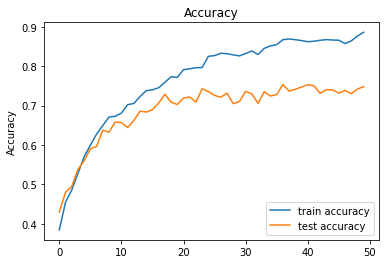

In [ ]:
# create accuracy sublpot
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.show()

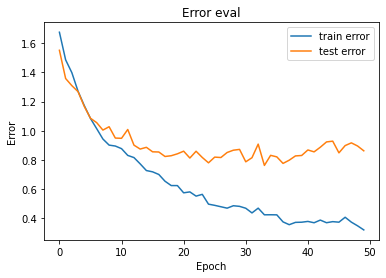

In [ ]:
plt.plot(history.history["loss"], label="train error")
plt.plot(history.history["val_loss"], label="test error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error eval");

In [ ]:
X = X_test[1][np.newaxis,...]
prediction = model.predict(X)
predicted_index = np.argmax(prediction, axis=1)
print(f"Expected index: {y_test[1]}, Predicted index: {predicted_index}")

Expected index: 7, Predicted index: [7]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
Y_pred = []
for i in range(len(y_pred)):
    Y_pred.append(np.argmax(y_pred[i]))

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       264
           1       0.98      0.93      0.95       240
           2       0.71      0.80      0.75       232
           3       0.91      0.82      0.86       238
           4       0.70      0.71      0.70       260
           5       0.67      0.81      0.73       253
           7       0.84      0.86      0.85       265
           8       0.73      0.66      0.69       233
           9       0.57      0.58      0.57       264

    accuracy                           0.75      2249
   macro avg       0.75      0.75      0.75      2249
weighted avg       0.75      0.75      0.75      2249



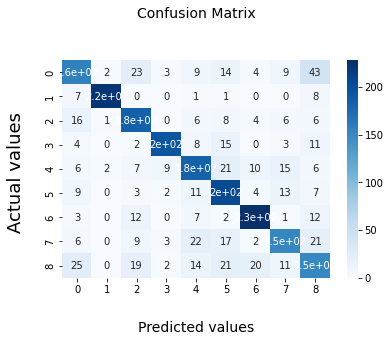

In [ ]:
cf_matrix = confusion_matrix(y_test, Y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n',fontdict = {'size':14}, pad = 10)
ax.set_xlabel('\nPredicted values',fontdict = {'size':14}, labelpad = 10)
ax.set_ylabel('Actual values ',fontdict = {'size':18}, labelpad = 20);

In [ ]:
accuracy = precision_score(y_test, Y_pred, average=None)
print("Accuracy for each class: ")
for i in range(len(accuracy)):
    if i > 5:
        j = i+1
        print(f"{j}:  {format(accuracy[i], '.2f')}%")
    else:
        print(f"{i}:  {format(accuracy[i], '.2f')}%")

Accuracy for each class: 
0:  0.67%
1:  0.98%
2:  0.71%
3:  0.91%
4:  0.70%
5:  0.67%
7:  0.84%
8:  0.73%
9:  0.57%


## Q.5) 
### (a) Implement A CNN-RNN (LSTM) Framework  using  (Keras/Tensorflow/Pytorch) for Crop Yield  Prediction (reference  paper, and dataset attached and other related  dataset is available at https://github.com/saeedkhaki92/CNN-RNN-Yield-Prediction). For implementation, use a Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for  RMSE as loss function  

### (i) Plot a comparative loss curve for at least 100 epochs.  
### (ii) Compare  for  Soybean  and Corn  yield prediction performance (RMSE and Correlation  Coefﬁcient)  for years 2016, 2017, and 2018 of 1D CNN, RNN(LSTM), and CNN- RNN(LSTM)  

In [ ]:
path = "/content/drive/MyDrive/nitk/assignments/assignment5/data5/"
x_corn = pd.read_csv(path+'corn_samples.csv')
y_corn = pd.read_csv(path+'corn_samples.csv')
x_soy = pd.read_csv(path+'soybean_samples.csv')
y_soy = pd.read_csv(path+'soybean_samples.csv')
print(x_corn.info())
x_corn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Columns: 397 entries, loc_ID to P_16
dtypes: float64(358), int64(39)
memory usage: 4.5 MB
None


,loc_ID,year,yield,W_1_1,W_1_2,W_1_3,W_1_4,W_1_5,W_1_6,W_1_7,...,P_7,P_8,P_9,P_10,P_11,P_12,P_13,P_14,P_15,P_16
0,0,1980,82.0,0.274725,0.000000,1.615385,0.395604,0.967033,0.736264,1.153846,...,38,40,8,4,0,0,0,0,0,0
1,0,1981,116.0,0.604396,0.000000,0.043956,0.000000,0.857143,1.824176,0.000000,...,13,30,16,11,12,7,3,0,0,0
2,0,1982,124.0,2.098901,0.384615,1.681319,0.527473,6.340659,1.593407,1.868132,...,47,14,5,2,1,0,0,0,0,0
3,0,1983,46.0,0.000000,0.000000,0.000000,1.032967,4.373626,0.351648,0.263736,...,11,24,22,17,6,5,3,0,0,0
4,0,1984,103.0,0.000000,0.043956,0.197802,0.461538,0.142857,0.670330,4.615385,...,6,35,33,10,4,8,0,0,0,0


In [ ]:
X_train = np.array(x_corn.drop(["yield","loc_ID","year"],axis = 1)) 
Y_train = np.array(x_corn["yield"])
for i in range(X_train.shape[-1]):
    diff = np.max(X_train[:,i]) - np.min(X_train[:,i])
    if(diff != 0):
        X_train[:,i] = (X_train[:,i]-np.mean(X_train[:,i]))/diff
    else:
        X_train[:,i] = 0
        
Y_train = Y_train/np.max(Y_train)

### Corn yield data

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(394)))
model.add(keras.layers.Reshape((394,1)))

model.add(keras.layers.Conv1D(16, activation='relu', kernel_size=(3)))
model.add(keras.layers.Conv1D(32, activation='relu', kernel_size=(3)))
model.add(keras.layers.MaxPool1D(pool_size=(2), strides=(2), padding='valid'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Reshape((4, 8)))

model.add(keras.layers.LSTM(8, return_sequences=True))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation=None))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 394, 1)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 392, 16)           64        
                                                                 
 conv1d_11 (Conv1D)          (None, 390, 32)           1568      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 195, 32)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 6240)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                399424    
                                                      

In [ ]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=10, batch_size=1)

Epoch 1/10
1499/1499 [==============================] - 24s 7ms/step - loss: 0.0020
Epoch 2/10
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0017
Epoch 3/10
1499/1499 [==============================] - 15s 10ms/step - loss: 0.0016
Epoch 4/10
1499/1499 [==============================] - 11s 7ms/step - loss: 0.0015
Epoch 5/10
1499/1499 [==============================] - 11s 7ms/step - loss: 0.0012
Epoch 6/10
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0012
Epoch 7/10
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0012
Epoch 8/10
1499/1499 [==============================] - 13s 9ms/step - loss: 0.0012
Epoch 9/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.0010
Epoch 10/10
1499/1499 [==============================] - 11s 7ms/step - loss: 0.0010


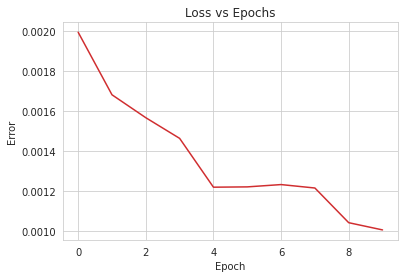

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.title("Loss vs Epochs");

### Soy yield data

In [ ]:
X_train = np.array(x_soy.drop("yield",axis = 1)) 
Y_train = np.array(x_soy["yield"])

for i in range(X_train.shape[-1]):
    diff = np.max(X_train[:,i]) - np.min(X_train[:,i])
    if(diff != 0):
        X_train[:,i] = (X_train[:,i]-np.mean(X_train[:,i]))/diff
    else:
        X_train[:,i] = 0
        
Y_train = Y_train/np.max(Y_train)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(394)))
model.add(keras.layers.Reshape((394,1)))

model.add(keras.layers.Conv1D(16, activation='relu', kernel_size=(3)))
model.add(keras.layers.Conv1D(32, activation='relu', kernel_size=(3)))
model.add(keras.layers.MaxPool1D(pool_size=(2), strides=(2), padding='valid'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Reshape((4, 8)))

model.add(keras.layers.LSTM(8, return_sequences=True))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation=None))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 394, 1)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 392, 16)           64        
                                                                 
 conv1d_7 (Conv1D)           (None, 390, 32)           1568      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 195, 32)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6240)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                399424    
                                                      

In [ ]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=1)

Epoch 1/10
1499/1499 [==============================] - 23s 10ms/step - loss: 0.0086
Epoch 2/10
1499/1499 [==============================] - 14s 9ms/step - loss: 0.0027
Epoch 3/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.0022
Epoch 4/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.0020
Epoch 5/10
1499/1499 [==============================] - 12s 8ms/step - loss: 0.0018
Epoch 6/10
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0016
Epoch 7/10
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0016
Epoch 8/10
1499/1499 [==============================] - 13s 9ms/step - loss: 0.0013
Epoch 9/10
1499/1499 [==============================] - 15s 10ms/step - loss: 0.0013
Epoch 10/10
1499/1499 [==============================] - 18s 12ms/step - loss: 0.0012


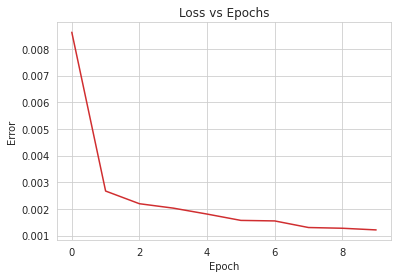

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.title("Loss vs Epochs");

### (b) Python Implementation  of  GRU  from Scratch (using NumPy)  for   Binary to  Deceimal  conversion. 

In [ ]:
temp = [np.random.randint(1023) for i in range(5000)]
x = np.array([[[int(j)] for j in '{0:010b}'.format(i)] for i in temp])
y = np.array([[[int(j)] for j in '{0:04d}'.format(i)] for i in temp])

In [ ]:
print(x.shape,y.shape)

(5000, 10, 1) (5000, 4, 1)


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.GRU(15, input_shape=(10,1),activation = 'tanh'))
model.add(keras.layers.Dense(15))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=50)

Epoch 1/50
157/157 [==============================] - 4s 7ms/step - loss: 10.2402
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 6.1409
Epoch 3/50
157/157 [==============================] - 1s 7ms/step - loss: 5.8122
Epoch 4/50
157/157 [==============================] - 1s 7ms/step - loss: 4.9820
Epoch 5/50
157/157 [==============================] - 1s 8ms/step - loss: 4.5869
Epoch 6/50
157/157 [==============================] - 1s 7ms/step - loss: 4.5398
Epoch 7/50
157/157 [==============================] - 1s 7ms/step - loss: 4.5190
Epoch 8/50
157/157 [==============================] - 1s 7ms/step - loss: 4.5037
Epoch 9/50
157/157 [==============================] - 1s 8ms/step - loss: 4.5030
Epoch 10/50
157/157 [==============================] - 1s 7ms/step - loss: 4.5056
Epoch 11/50
157/157 [==============================] - 1s 8ms/step - loss: 4.4907
Epoch 12/50
157/157 [==============================] - 1s 8ms/step - loss: 4.4854
Epoch 13/50
157/157 [===

In [ ]:
test = np.array([[[0],[0],[0],[0],[0],[1],[0],[1],[1],[0]]])
print("Binary: ",test)
prediction = model.predict(test)
print("Decimal: ",np.round(prediction[0]))

Binary:  [[[0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [1]
  [1]
  [0]]]
Decimal:  [0. 0. 2. 4.]
